<a href="https://colab.research.google.com/github/rishpaul04/NeuroGuard/blob/main/3rdYR_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Successfully loaded dataset: (10000, 18)

Columns in the dataframe:
['Patient_ID', 'Timestamp', 'EEG_Alpha', 'EEG_Beta', 'EEG_Theta', 'EEG_Delta', 'HeartRate_BPM', 'HRV_RMSSD', 'EDA_Level (ÂµS)', 'Accel_X (m/sÂ²)', 'Accel_Y (m/sÂ²)', 'Accel_Z (m/sÂ²)', 'Gait_Speed (m/s)', 'Skin_Temp (Â°C)', 'GPS_Latitude', 'GPS_Longitude', 'Fall_Detected (0/1)', 'Stage_Label']

--- Performing Feature Engineering ---
New shape after adding features: (10000, 21)

Features used for training:
['EEG_Alpha', 'EEG_Beta', 'EEG_Theta', 'EEG_Delta', 'HeartRate_BPM', 'HRV_RMSSD', 'EDA_Level (ÂµS)', 'Accel_X (m/sÂ²)', 'Accel_Y (m/sÂ²)', 'Accel_Z (m/sÂ²)', 'Gait_Speed (m/s)', 'Skin_Temp (Â°C)', 'GPS_Latitude', 'GPS_Longitude', 'Fall_Detected (0/1)', 'EEG_Alpha_Beta_Ratio', 'EEG_Theta_Delta_Ratio', 'Accel_Magnitude']

Train set size: (8000, 18), Test set size: (2000, 18)

--- Starting Hyperparameter Tuning with SMOTE ---
Fitting 5 folds for each of 72 candidates, totalling 360 fits
[LightGBM] [Info] Auto-choosing co

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Final Test Accuracy: 0.9885
✅ Goal achieved: Model accuracy is above 90%!

Classification Report:
              precision    recall  f1-score   support

     Control       1.00      1.00      1.00       800
        Mild       0.99      0.99      0.99       600
    Moderate       0.97      0.98      0.98       400
      Severe       0.98      0.95      0.97       200

    accuracy                           0.99      2000
   macro avg       0.99      0.98      0.98      2000
weighted avg       0.99      0.99      0.99      2000



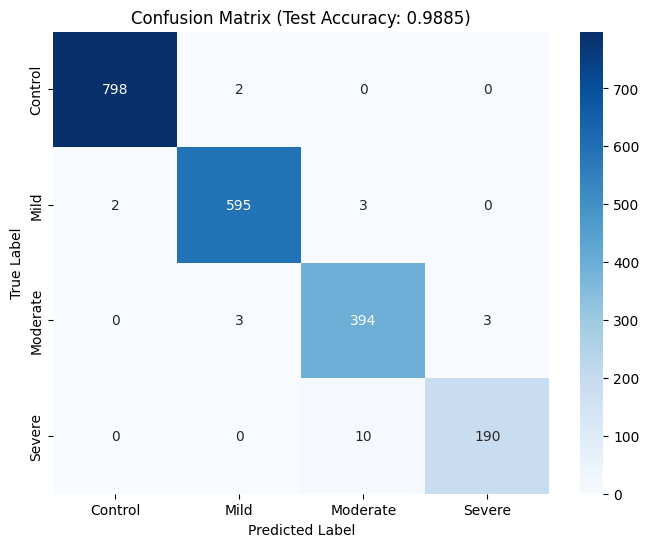

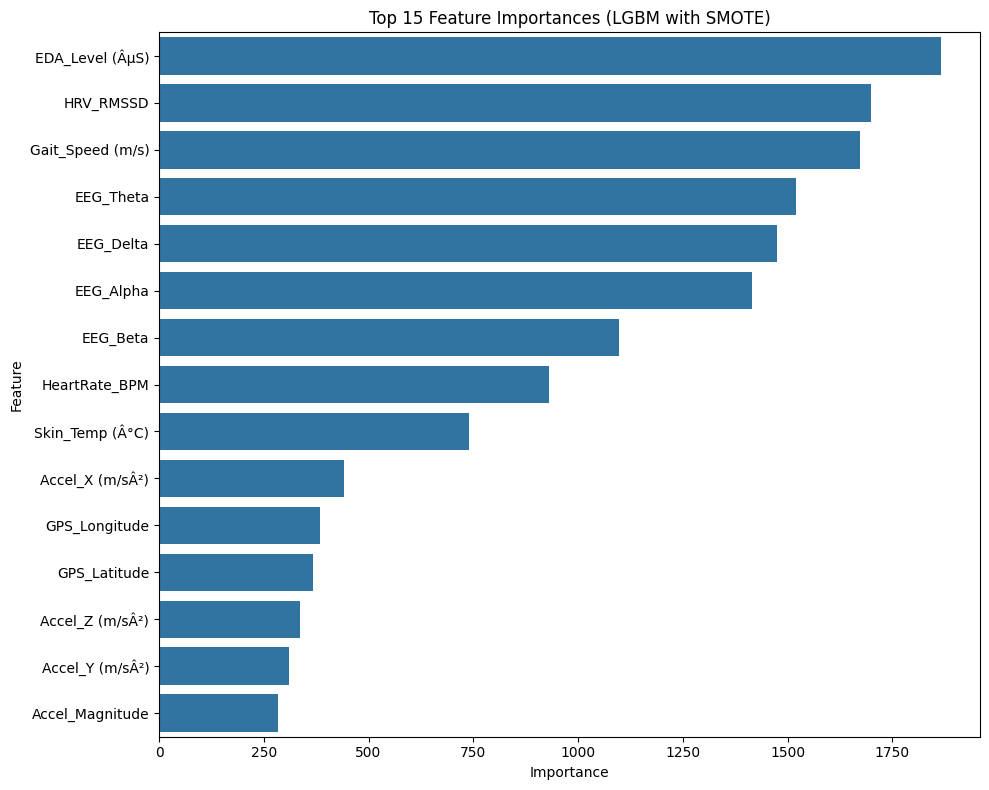


Best model saved to: lgbm_alzheimers_advanced_model.joblib
Label encoder saved to: label_encoder_advanced.joblib


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import lightgbm as lgb
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import time

# ----- 0. Configuration & Data Loading -----
# IMPORTANT: Use the new dataset generated by the script above
# Note: In Google Colab, file paths should typically use forward slashes and point to files in the Colab environment.
# If your file is on your local machine, you'll need to upload it to Colab or use Google Drive mounting.
CSV_PATH = "/content/alzheimers_dataset_4_classes.xlsx" # Example path for Colab

MODEL_SAVE_PATH = 'lgbm_alzheimers_advanced_model.joblib'
SCALER_SAVE_PATH = 'scaler_advanced.joblib'
ENCODER_SAVE_PATH = 'label_encoder_advanced.joblib'

try:
    df = pd.read_excel(CSV_PATH) # Use pd.read_excel for .xlsx files
    print(f"Successfully loaded dataset: {df.shape}")
    print("\nColumns in the dataframe:")
    print(df.columns.tolist()) # Print column names to identify the correct ones

except FileNotFoundError:
    print(f"Error: The file '{CSV_PATH}' was not found.")
    print("Please ensure the file exists at this path or update the CSV_PATH variable.")
    # Removed exit() to allow execution to continue, though subsequent steps will fail without the dataframe
except Exception as e:
    print(f"An error occurred while loading the file: {e}")


# ----- 1. Feature Engineering -----
# Only proceed if df is defined
if 'df' in locals():
    print("\n--- Performing Feature Engineering ---")
    # Create interaction features that can be highly predictive
    df['EEG_Alpha_Beta_Ratio'] = df['EEG_Alpha'] / (df['EEG_Beta'] + 1e-6)
    df['EEG_Theta_Delta_Ratio'] = df['EEG_Theta'] / (df['EEG_Delta'] + 1e-6)
    df['Accel_Magnitude'] = np.sqrt(df['Accel_X (m/sÂ²)']**2 + df['Accel_Y (m/sÂ²)']**2 + df['Accel_Z (m/sÂ²)']**2)

    print(f"New shape after adding features: {df.shape}")

    # ----- 2. Prepare Features & Labels -----
    X = df.drop(columns=['Patient_ID', 'Timestamp', 'Stage_Label'])
    y = df['Stage_Label']

    # Encode labels to numerical format
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    print("\nFeatures used for training:")
    print(X.columns.tolist())

    # ----- 3. Train/Test Split -----
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )
    print(f"\nTrain set size: {X_train.shape}, Test set size: {X_test.shape}")


    # ----- 4. Define Advanced Model Pipeline with SMOTE -----
    # Use a pipeline from imblearn to correctly apply SMOTE only to the training data during cross-validation
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)), # Apply SMOTE to handle class imbalance
        ('lgbm', lgb.LGBMClassifier(random_state=42))
    ])

    # ----- 5. Hyperparameter Tuning with GridSearchCV -----
    # Refined grid for finding a high-performance model
    param_grid = {
        'lgbm__n_estimators': [200, 300, 400],
        'lgbm__learning_rate': [0.05, 0.1],
        'lgbm__num_leaves': [40, 50, 60],
        'lgbm__reg_alpha': [0.1, 0.2],
        'lgbm__reg_lambda': [0.1, 0.2]
    }

    # Use Stratified K-Fold for robust cross-validation
    cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    print("\n--- Starting Hyperparameter Tuning with SMOTE ---")
    grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               cv=cv_strategy,
                               scoring='accuracy',
                               n_jobs=-1,
                               verbose=2)

    start_time = time.time()
    grid_search.fit(X_train, y_train)
    end_time = time.time()

    print(f"\n--- Grid Search Finished in {(end_time - start_time) / 60:.2f} minutes ---")
    print(f"Best parameters found: {grid_search.best_params_}")
    print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

    # ----- 6. Evaluate the Best Model Found -----
    print("\n--- Evaluating Best Model on the Test Set ---")
    best_model = grid_search.best_estimator_

    # Make predictions on the unseen test data
    y_pred = best_model.predict(X_test)

    # Print metrics
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nFinal Test Accuracy: {accuracy:.4f}")
    if accuracy > 0.90:
        print("✅ Goal achieved: Model accuracy is above 90%!")
    else:
        print("❌ Goal not met. The data might still be too complex or more features are needed.")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))


    # ----- 7. Visualize Results -----
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Confusion Matrix (Test Accuracy: {accuracy:.4f})')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Plot feature importance from the best model
    feature_importances = best_model.named_steps['lgbm'].feature_importances_
    feature_names = X.columns
    importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    importance_df = importance_df.sort_values('importance', ascending=False).head(15)

    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=importance_df)
    plt.title('Top 15 Feature Importances (LGBM with SMOTE)')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()


    # ----- 8. Save the Final Model and Artifacts -----
    joblib.dump(best_model, MODEL_SAVE_PATH)
    joblib.dump(le, ENCODER_SAVE_PATH)

    print(f"\nBest model saved to: {MODEL_SAVE_PATH}")
    print(f"Label encoder saved to: {ENCODER_SAVE_PATH}")
else:
    print("\nSkipping model training and evaluation due to file loading error.")